In [106]:
import pandas as pd
import geopandas as gpd
import numpy as np
import requests as re
import folium
import h3 
import tqdm
import requests
import json
import time
import os
import math
import ast

from shapely import geometry
from shapely.ops import unary_union, transform
 
pd.set_option('display.max_columns',None)
API_KEY = 'API_KEY_HERE'

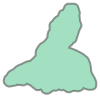

In [107]:
# shapefiles will be provided in the github repository
districts_gpd = gpd.read_file('../data/admin_boundaries/Adminbdy Shapefile/District_Boundary.shp')
karachi_districts = ['KARACHI CENTRAL', 'KARACHI WEST', 'MALIR CANTONMENT',
       'KORANGI CREEK CANTONMENT', 'MANORA CANTONMENT',
       'CLIFTON CANTONMENT', 'KARACHI CANTONMENT', 'FAISAL CANTONMENT',
       'KARACHI SOUTH', 'MALIR', 'KORANGI', 'KARACHI EAST']

# unary union to combine all districts into one polygon object
khi_boundaries = unary_union(districts_gpd[districts_gpd\
  .DISTRICT\
  .isin(karachi_districts)==True]['geometry'])

# small buffer to smoothen the edges
khi_boundaries = khi_boundaries.buffer(0.05)
khi_boundaries

In [108]:
# flip coordinate sequence from longitude, latitude to latitude, longitude as this is how the h3 API reads it
def flip(x,y):
    return y,x
khi_boundaries = transform(flip,khi_boundaries)

# convert to plan geojson object
khi_boundaries_gejson = gpd.GeoSeries([khi_boundaries])\
    .__geo_interface__['features'][0]['geometry']

# get h3 cell IDs for cells within the bounding polygon / geojson
res6_khi_hex = h3.polyfill(khi_boundaries_gejson,6)

In [113]:
def func_visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    original source: https://nbviewer.org/github/uber/h3-py-notebooks/blob/master/notebooks/usage.ipynb

    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium\
            .Map(location=[sum(lat)/len(lat),
                        sum(lng)/len(lng)],
                        zoom_start=9, 
                        tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=2,color=color)
        m.add_child(my_PolyLine)
    return m

m = func_visualize_hexagons(hexagons=res6_khi_hex)
display(m)

In [6]:
def func_get_places_poi(lat,lng,resolution,type,api_key):
    
    # nearby sarch API URL
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    params = {
    'location': f'{lat},{lng}',
    'radius': resolution,
    'types': type,
    'key': api_key}

    response = requests.get(url, params=params)
    places_df = []

    results = json.loads(response.content)

    places_df.append(results['results'])

    while 'next_page_token' in results:
        time.sleep(1)
        params['pagetoken'] = results['next_page_token']
        response = requests.get(url,params=params)
        results = json.loads(response.content)
        places_df.append(results['results'])
        
    results_df = pd.concat([pd.DataFrame(df) for df in places_df])
    results_df = results_df.reset_index(drop=True)
    
    return results_df

# Location for Karachi DHA Phase 6, Khayaban-e-Sehar
lat,lng = 24.794386, 67.048928

# see all POI types for places API here: https://developers.google.com/maps/documentation/places/web-service/supported_types
results_df = func_get_places_poi(lat=lat,lng=lng,
                                 resolution=2000,
                                 type='cafe', 
                                 api_key=API_KEY)

results_df[['place_id','name','types','user_ratings_total','vicinity']].head()

,place_id,name,types,user_ratings_total,vicinity
0,ChIJt2wE9OI8sz4RtXVbnXWIa-8,MOCCA COFFEE,"[cafe, store, restaurant, food, point_of_inter...",1400.0,"48-C Khayaban-e-Shahbaz, D.H.A Phase 6 Commerc..."
1,ChIJC9ORzu48sz4RU7Bt-me2WbM,Chai Wala,"[cafe, food, point_of_interest, establishment]",4662.0,"Shop 2 & 3, Plot # 1C, Chota, Bukhari Commerci..."
2,ChIJ6TbLBe08sz4RPCw74iFWLnc,Xander's DHA Bukhari,"[restaurant, cafe, food, point_of_interest, es...",3097.0,"48-C, Bukhari Commercial, Lane 13, Main Khayab..."
3,ChIJZeUxGuw8sz4RwKlPPnbIaGo,Chotu Chai Wala,"[cafe, food, point_of_interest, establishment]",2516.0,Plot no 13/C Street no 16 Bara Bukhari opposit...
4,ChIJmzhi_vY8sz4RZEd9ZN78oK0,Delizia Bakery Shahbaz Commercial Area,"[bakery, cafe, store, food, point_of_interest,...",227.0,"27-E Khayaban-e-Seher, D.H.A Phase 6 Shahbaz C..."


In [115]:
res6_khi_hex = pd.DataFrame({'hex_id':list(res6_khi_hex),'hex_resolution':6})

res7_khi_hex = h3.polyfill(khi_boundaries_gejson,7)
res7_khi_hex = pd.DataFrame({'hex_id':list(res7_khi_hex),'hex_resolution':7})

res8_khi_hex = h3.polyfill(khi_boundaries_gejson,8)
res8_khi_hex = pd.DataFrame({'hex_id':list(res8_khi_hex),'hex_resolution':8})

res9_khi_hex = h3.polyfill(khi_boundaries_gejson,9)
res9_khi_hex = pd.DataFrame({'hex_id':list(res9_khi_hex),'hex_resolution':9})

khi_hex_df = pd.concat([res6_khi_hex,res7_khi_hex,res8_khi_hex,res9_khi_hex])
khi_hex_df.reset_index(drop=True,inplace=True)

def func_get_hex_radius(row,BUFFER):
    area_sq_meters = h3.cell_area(row.hex_id,unit='m^2')
    side_length = math.sqrt((2 * area_sq_meters) / (3 * math.sqrt(3)))
    radius = side_length / math.sqrt(3)
    radius_buffer = radius*BUFFER
    radius = radius + radius_buffer
    return radius

khi_hex_df['hex_area'] = khi_hex_df.hex_id.apply(lambda x: h3.cell_area(x,unit='m^2'))
khi_hex_df['hex_radius_places_api'] = khi_hex_df.apply(lambda row: func_get_hex_radius(row,0.1),axis=1)
khi_hex_df['centroid'] = khi_hex_df.hex_id.apply(lambda x: h3.h3_to_geo(x))
khi_hex_df.head()

,hex_id,hex_resolution,hex_area,hex_radius_places_api,centroid
0,8642e4177ffffff,6,3.551023e+07,2347.917664,"(25.392522163860068, 67.15654907799981)"
1,864219207ffffff,6,3.505143e+07,2332.700411,"(24.821812748149885, 66.62539274525035)"
2,8642e459fffffff,6,3.505380e+07,2332.779209,"(24.776164400363722, 66.96756433198478)"
3,8642e418fffffff,6,3.536737e+07,2343.189804,"(25.192947367159913, 67.13610794151774)"
4,8642e468fffffff,6,3.514200e+07,2335.712264,"(24.81942471509276, 67.58724367739511)"


In [47]:
#res 6 ~ 2200m
#Get the highest resolution cells
max_khi_hex_df = khi_hex_df[khi_hex_df.hex_resolution==khi_hex_df.hex_resolution.min()]

# We created a seperate folder to store all output, in case the code is interrupted we can use
# this list to make sure we're not repeating any cells.

searched_cells = os.listdir(f'../data/h3cell_output_cafe/')
searched_cells = set([x.replace('.csv','') for x in searched_cells])

# Setting POI type for cafe.
type = 'cafe'

for ind,row in tqdm.tqdm(max_khi_hex_df.iterrows(),
                         total=max_khi_hex_df.shape[0]):
    
    #parsing the highest resolution cells and saving outputs in a csv file
    h3_cell = row.hex_id
    if(h3_cell not in searched_cells):
        lat,lng = row.centroid[0],row.centroid[1]
        resolution = row.hex_radius_places_api
        # Call the Places using the the function we wrote earlier
        df = func_get_places_poi(lat=lat,lng=lng,resolution=resolution,type=type,api_key=API_KEY)
        df['hex_id'] = h3_cell
        cell_save_path = f'../data/h3cell_output_{type}/{h3_cell}.csv'
        df.to_csv(cell_save_path,index=False)
        
        # Key part of the algorithm, if the API returns equal or more than 60 results
        if(len(df)>=60):
            cell_children = h3.h3_to_children(df['hex_id'][0])
            child_df = khi_hex_df[khi_hex_df.hex_id.isin(cell_children)]
            
            #res 7 ~ 900m
            for ind,row in child_df.iterrows():
                h3_cell = row.hex_id
                lat,lng = row.centroid[0],row.centroid[1]
                resolution = row.hex_radius_places_api
                df = func_get_places_poi(lat=lat,lng=lng,resolution=resolution,type=type,api_key=API_KEY)
                df['hex_id'] = h3_cell
                cell_save_path = f'../data/h3cell_output_{type}/{h3_cell}.csv'
                df.to_csv(cell_save_path,index=False)

                # Repeat same logic as above and all other resolutions  
                if(len(df)>=60):
                    cell_children = h3.h3_to_children(df['hex_id'][0])
                    child_df = khi_hex_df[khi_hex_df.hex_id.isin(cell_children)]

                    # res 8 ~ 400m
                    for ind,row in child_df.iterrows():
                        h3_cell = row.hex_id
                        lat,lng = row.centroid[0],row.centroid[1]
                        resolution = row.hex_radius_places_api
                        df = func_get_places_poi(lat=lat,lng=lng,resolution=resolution,type=type,api_key=API_KEY)
                        df['hex_id'] = h3_cell
                        cell_save_path = f'../data/h3cell_output_{type}/{h3_cell}.csv'
                        df.to_csv(cell_save_path,index=False)

                        # You can go as deep as you want, down to res 9 and res 10 similary
                        # Yes, this should be a recursive funciton but I'll leave that to you? :)





100%|██████████| 161/161 [04:40<00:00,  1.74s/it]


In [59]:
# We can see that the algorithm did search 34 lower resolution hexagons,
# where we managed to saturate the API at a higher reesolution.
paths = os.listdir('../data/h3cell_output_cafe')
paths = ['../data/h3cell_output_cafe/'+path for path in paths]
n_df = pd.concat([pd.read_csv(path) for path in paths])
khi_hex_df[khi_hex_df\
           .hex_id\
           .isin(n_df.hex_id.unique())]\
           .hex_resolution.value_counts()

hex_resolution
6    56
7    34
Name: count, dtype: int64

In [114]:
n_df = n_df.drop_duplicates(subset='place_id')
n_df = n_df.reset_index(drop=True)
n_df['location'] = n_df.geometry.apply(lambda x: ast.literal_eval(x)['location'])
n_df['lat'] = n_df['location'].apply(lambda x: x['lat'])
n_df['lng'] = n_df['location'].apply(lambda x: x['lng'])
for ind,row in n_df.iterrows():
    lat = row.lat
    lng = row.lng
    folium.CircleMarker(location=(lat,lng),
                        radius=5,
                        color='blue').add_to(m)
m